In [3]:
import discretize
from discretize import utils
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
from scipy.constants import mu_0, inch, foot
import ipywidgets

from SimPEG.EM import FDEM
from SimPEG import Utils, Maps

import casingSimulations as casingSim

from pymatsolver import Pardiso

%matplotlib inline

In [4]:
simDir = 'FDEM_Augustin'  # create a simulation directory where results can be saved. 

In [5]:
casing_mur = [1, 100]
sigma_casing = [1e6, 1e8]
sigma_permeable_casing = 1e6

In [6]:
sigma_air = 1e-4
sigma_back = 1e-4
casing_t = 10e-3 # 10mm thick casing
casing_d = 100e-3 # 10cm diameter
casing_l = 2000

def get_model(mur, sig):
    model = casingSim.model.CasingInHalfspace(
        directory = simDir,
        sigma_air = sigma_air,
        sigma_casing = sig,  # conductivity of the casing (S/m)
        sigma_back = sigma_back,  # conductivity of the background (S/m)
        sigma_inside = sigma_back,  # fluid inside the well has same conductivity as the background
        casing_d = casing_d-casing_t,  # 135mm is outer casing diameter
        casing_l = casing_l,
        casing_t = casing_t, 
        mur_casing = mur,
        src_a = np.r_[0., 0., 0.],
        src_b = np.r_[0., 0., 0.]
    )
 
    return model

In [7]:
model_names_permeable = ["casing_{}".format(mur) for mur in casing_mur]
model_names_conductive = ["casing_{:1.0e}".format(sig) for sig in sigma_casing]

In [8]:
# conductive, permeable models
model_dict_permeable = {
    key: get_model(mur, sigma_permeable_casing) for key, mur in zip(model_names_permeable, casing_mur)
}

model_dict_conductive = {
    key: get_model(1, sig) for key, sig in zip(model_names_conductive, sigma_casing)
}

model_names = model_names_conductive + model_names_permeable
model_dict = {}
model_dict.update(model_dict_permeable)
model_dict.update(model_dict_conductive)

In [9]:
model_dict["baseline"] = model_dict[model_names[0]].copy()
model_dict["baseline"].sigma_casing = model_dict["baseline"].sigma_back
model_names = ["baseline"] + model_names
model_names

['baseline', 'casing_1e+06', 'casing_1e+08', 'casing_1', 'casing_100']

In [150]:
freqs = np.logspace(-2, 4, 60)
# freqs = [0.01, 0.1, 1, 10, 100, 1000]
for mod in model_dict.values():
    mod.freqs = freqs

In [151]:
# parameters defining the core region of the mesh
# note that the finest re
csx2 = 25.  # cell size in the x-direction in the second uniform region of the mesh (where we measure data)
csz = 2.5  # cell size in the z-direction 
domainx2 = 100  # go out 500m from the well

# padding parameters
npadx, npadz = 20, 27  # number of padding cells
pfx2 = 1.4  # expansion factor for the padding to infinity in the x-direction
pfz = 1.4


# # theta discretization
# hy = utils.meshTensor([(1, 2, -1.5), (1, 3), (1, 2, 1.5)])
# hy = np.r_[hy, hy]
# hy = hy*2*np.pi / hy.sum()


# set up a mesh generator which will build a mesh based on the provided parameters
# and casing geometry
def get_mesh(mod):
    return casingSim.CasingMeshGenerator(
        directory=simDir,  # directory where we can save things
        modelParameters=mod,  # casing parameters
        npadx=npadx,  # number of padding cells in the x-direction
        npadz=npadz,  # number of padding cells in the z-direction
        domain_x=domainx2,  # extent of the second uniform region of the mesh 
#         hy=hy,   # cell spacings in the 
        csx1=mod.casing_t/4.,  # use at least 4 cells per across the thickness of the casing
        csx2=csx2,  # second core cell size
        csz=csz,  # cell size in the z-direction
        pfx2=pfx2,  # padding factor to "infinity"
        pfz=pfz  # padding factor to "infinity" for the z-direction
    )

In [152]:
mesh_generator = get_mesh(model_dict[model_names[0]])

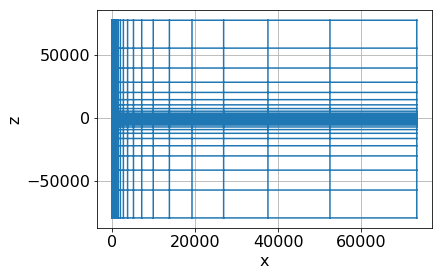

In [153]:
mesh_generator.mesh.plotGrid()

In [154]:
model_dict[model_names[0]].skin_depth().max()

503292.12104487035

In [155]:
# Assign physical properties on the mesh
physpropsDict = {
    name: casingSim.model.PhysicalProperties(mesh_generator, mod) 
    for name, mod in model_dict.iteritems()
}

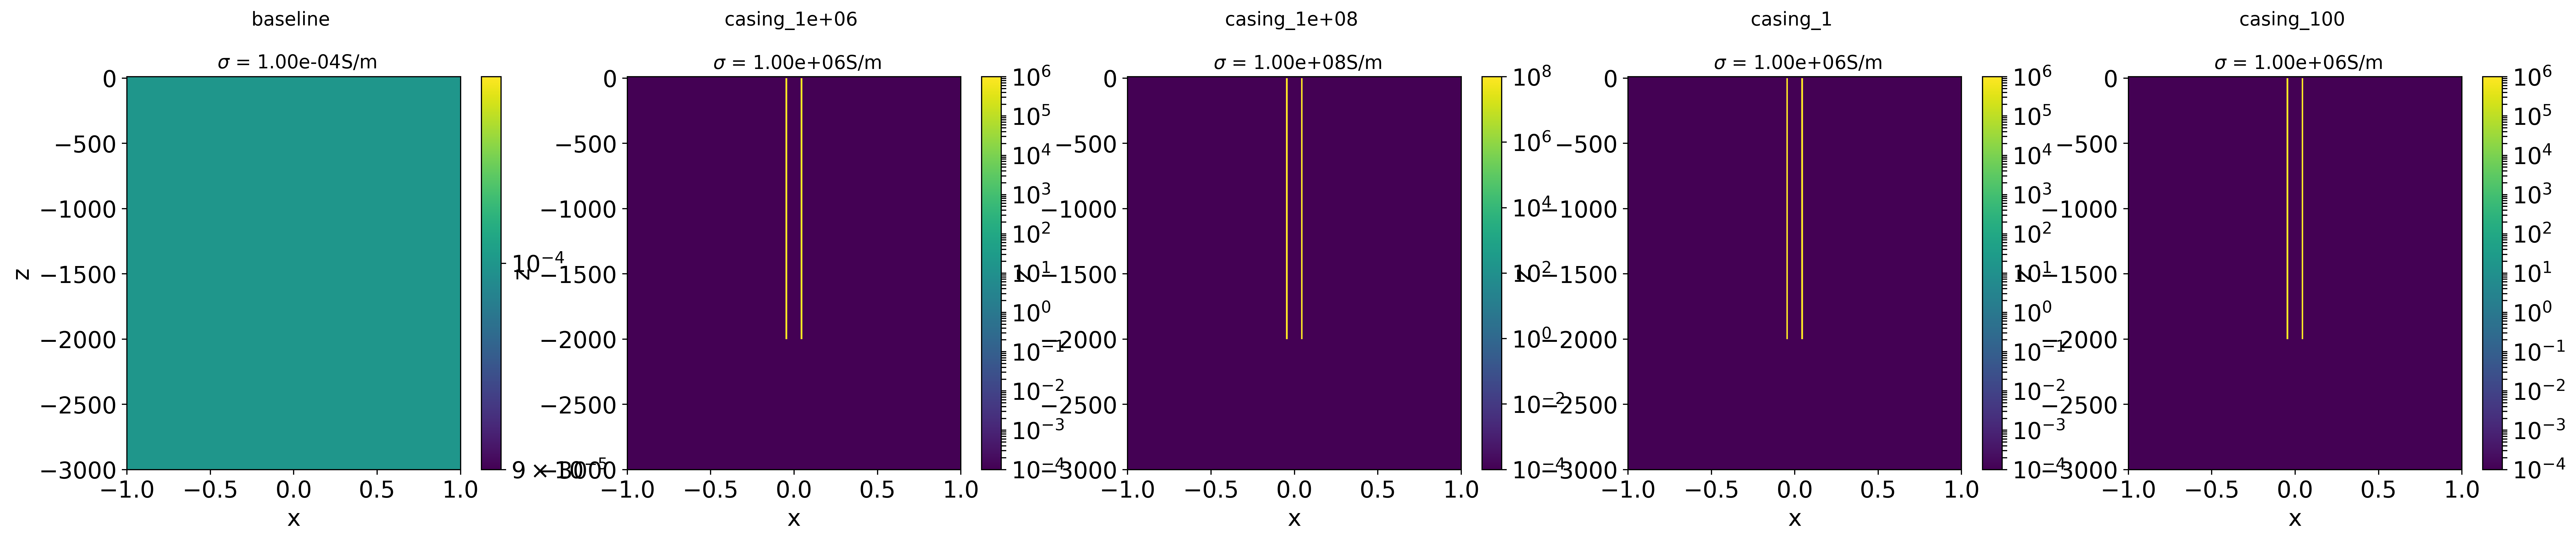

In [156]:
# Plot the models
xlim = np.r_[-1, 1]  # x-limits in meters
zlim = np.r_[-1.5*casing_l, 10.]  # z-limits in meters. (z-positive up)

fig, ax = plt.subplots(1, len(model_names), figsize=(6*len(model_names), 5), dpi=350)
if len(model_names) == 1:
    ax = [ax]
    
for a, title in zip(ax, model_names):
    pp = physpropsDict[title]
    pp.plot_sigma(
        ax=a, 
        pcolorOpts={'norm':LogNorm()}  # plot on a log-scale
    )
    a.set_title('{} \n\n $\sigma$ = {:1.2e}S/m'.format(title, pp.modelParameters.sigma_casing), fontsize=13)
#     cylMeshGen.mesh.plotGrid(ax=a, slice='theta') # uncomment to plot the mesh on top of this
    a.set_xlim(xlim)
    a.set_ylim(zlim)

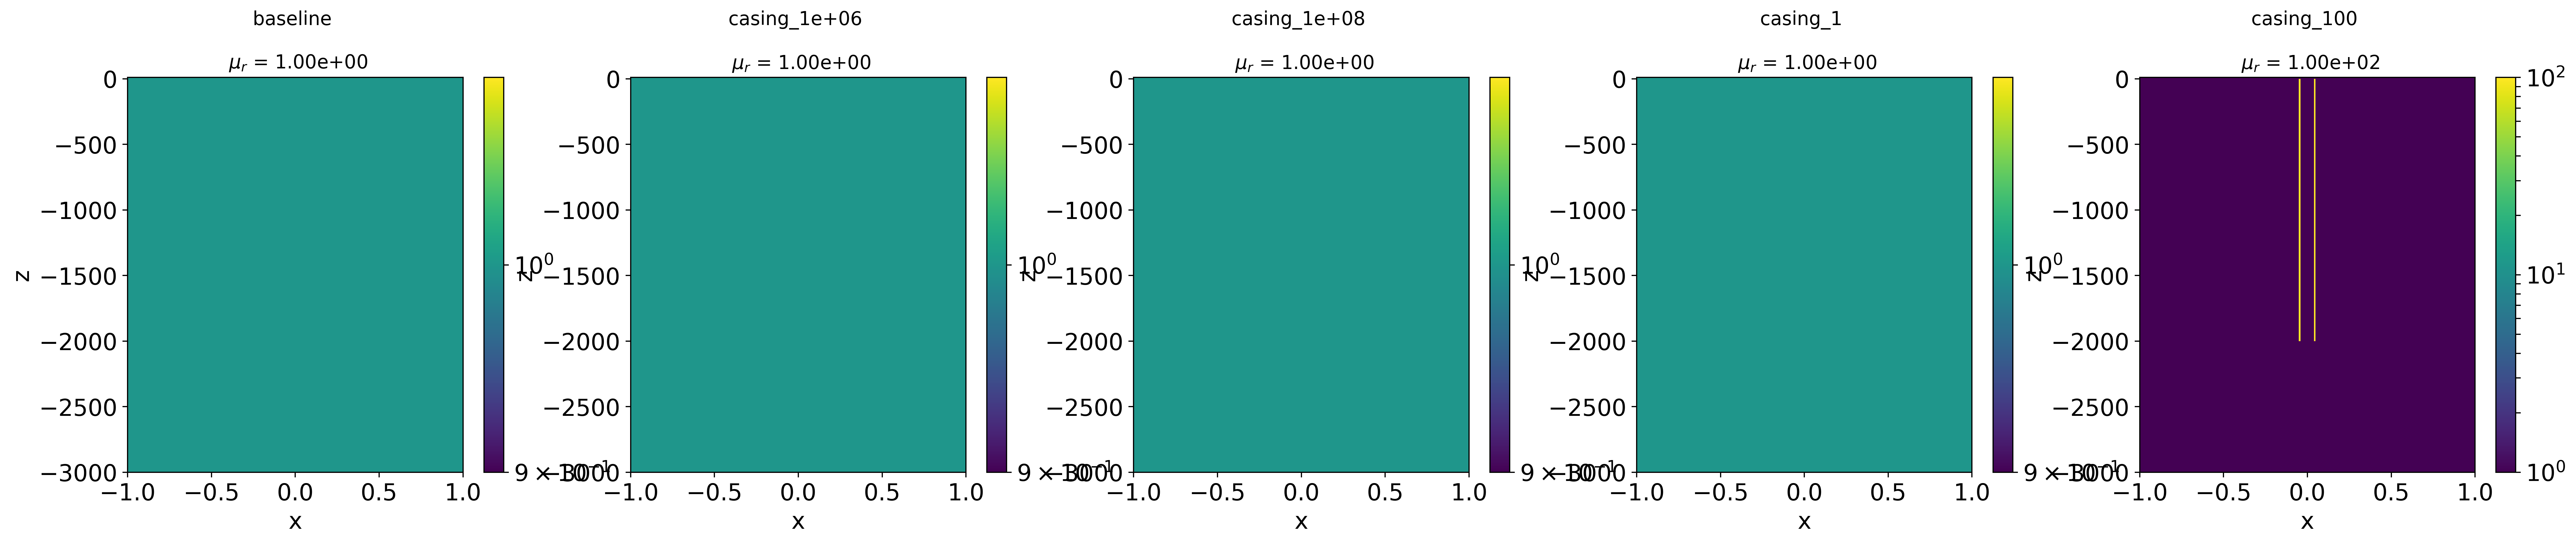

In [157]:
# Plot the models
xlim = np.r_[-1, 1]  # x-limits in meters
zlim = np.r_[-1.5*casing_l, 10.]  # z-limits in meters. (z-positive up)

fig, ax = plt.subplots(1, len(model_names), figsize=(6*len(model_names), 5), dpi=350)
if len(model_names) == 1:
    ax = [ax]
    
for a, title in zip(ax, model_names):
    pp = physpropsDict[title]
    pp.plot_mur(
        ax=a, 
        pcolorOpts={'norm':LogNorm()}  # plot on a log-scale
    )
    a.set_title('{} \n\n $\mu_r$ = {:1.2e}'.format(title, pp.modelParameters.mur_casing), fontsize=13)
#     cylMeshGen.mesh.plotGrid(ax=a, slice='theta') # uncomment to plot the mesh on top of this
    a.set_xlim(xlim)
    a.set_ylim(zlim)

In [158]:
rx_loc = np.array([[0., 0., -500.]])

In [159]:
rx_re = FDEM.Rx.Point_bSecondary(rx_loc, orientation="z", component="real")
rx_im = FDEM.Rx.Point_bSecondary(rx_loc, orientation="z", component="imag")

In [160]:
# for src in src_list: 
#     src.rxList=[rx_re, rx_im]

In [161]:
loop_radius = 100
src_list = [FDEM.Src.CircularLoop(
    [rx_re, rx_im], f, np.r_[0., 0., 0.], orientation="z", moment=1, radius=100
) for f in freqs]

In [162]:
wires = physpropsDict[model_names[0]].wires
wires.sigma

In [163]:
prob = FDEM.Problem3D_e(mesh=mesh_generator.mesh, sigmaMap=wires.sigma, muMap=wires.mu, Solver=Pardiso)

In [164]:
survey = FDEM.Survey(src_list)
prob.pair(survey)

In [165]:
fields_dict = {}

In [166]:
import time

In [167]:
model_names

['baseline', 'casing_1e+06', 'casing_1e+08', 'casing_1', 'casing_100']

In [168]:
%%time
for key in model_names:
    if key not in fields_dict.keys():
        t = time.time()
        print('--- Running {} ---'.format(key))
        fields_dict[key] = prob.fields(physpropsDict[key].model)
        print(" ... done. Elapsed time {}".format(time.time() - t))
        print('\n')

--- Running baseline ---
 ... done. Elapsed time 26.0194630623


--- Running casing_1e+06 ---
 ... done. Elapsed time 24.4694519043


--- Running casing_1e+08 ---
 ... done. Elapsed time 26.3641679287


--- Running casing_1 ---
 ... done. Elapsed time 31.1614410877


--- Running casing_100 ---
 ... done. Elapsed time 30.7515058517


CPU times: user 3min 42s, sys: 28.2 s, total: 4min 10s
Wall time: 2min 18s


In [169]:
for src in survey.srcList:
    src.rxList=[rx_re, rx_im]

In [170]:
data_dict = {}
for key in model_names:
    model = physpropsDict[key].model
    prob.model = model
    data_dict[key] = survey.dpred(model, f=fields_dict[key])

In [175]:
def plot_response_fct(ax=None, subtract=None, models=None, colors=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, dpi=400)
    
    if colors is None:
        colors = ["C{}".format(i if i < 10 else i - 10) for i in range(len(models))]
    plot_models = model_names[1:]
    if models is not None:
        if type(models) == str:
            if models.lower() == "permeable":
                plot_models = model_names_permeable
            elif models.lower() == "conductive":
                plot_models = model_names_conductive
        else:
            plot_models = models
        
            
        
    for i, key in enumerate(plot_models):
        bPrimary = rx_re.getP(mesh_generator.mesh) * src_list[i].bPrimary(prob)
        data = (data_dict[key]).copy()
        prob.model = physpropsDict[key].model
        data_re = data[0::2] / bPrimary
        data_im = data[1::2] / bPrimary
        
        if subtract is not None:
            if subtract.lower() == "conductive":
                data_re -= data_dict["casing_1"][0::2] / bPrimary 
                data_im -= data_dict["casing_1"][1::2] / bPrimary
        
        label = "$\sigma$ = {:1.0e}, $\mu_r$ = {:1.0f}".format(
            model_dict[key].sigma_casing, model_dict[key].mur_casing 
        )
        ax.semilogx(freqs, data_re, color=colors[i], label=label)
        ax.semilogx(freqs, data_im, color=colors[i], linestyle="--")
        
    ax.legend(fontsize=8)
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("NSF")
    ax.grid(which='both', alpha=0.4)
    # ax.set_ylabel()
#     plt.show()

In [179]:
from matplotlib import rcParams
rcParams['font.size'] = 10

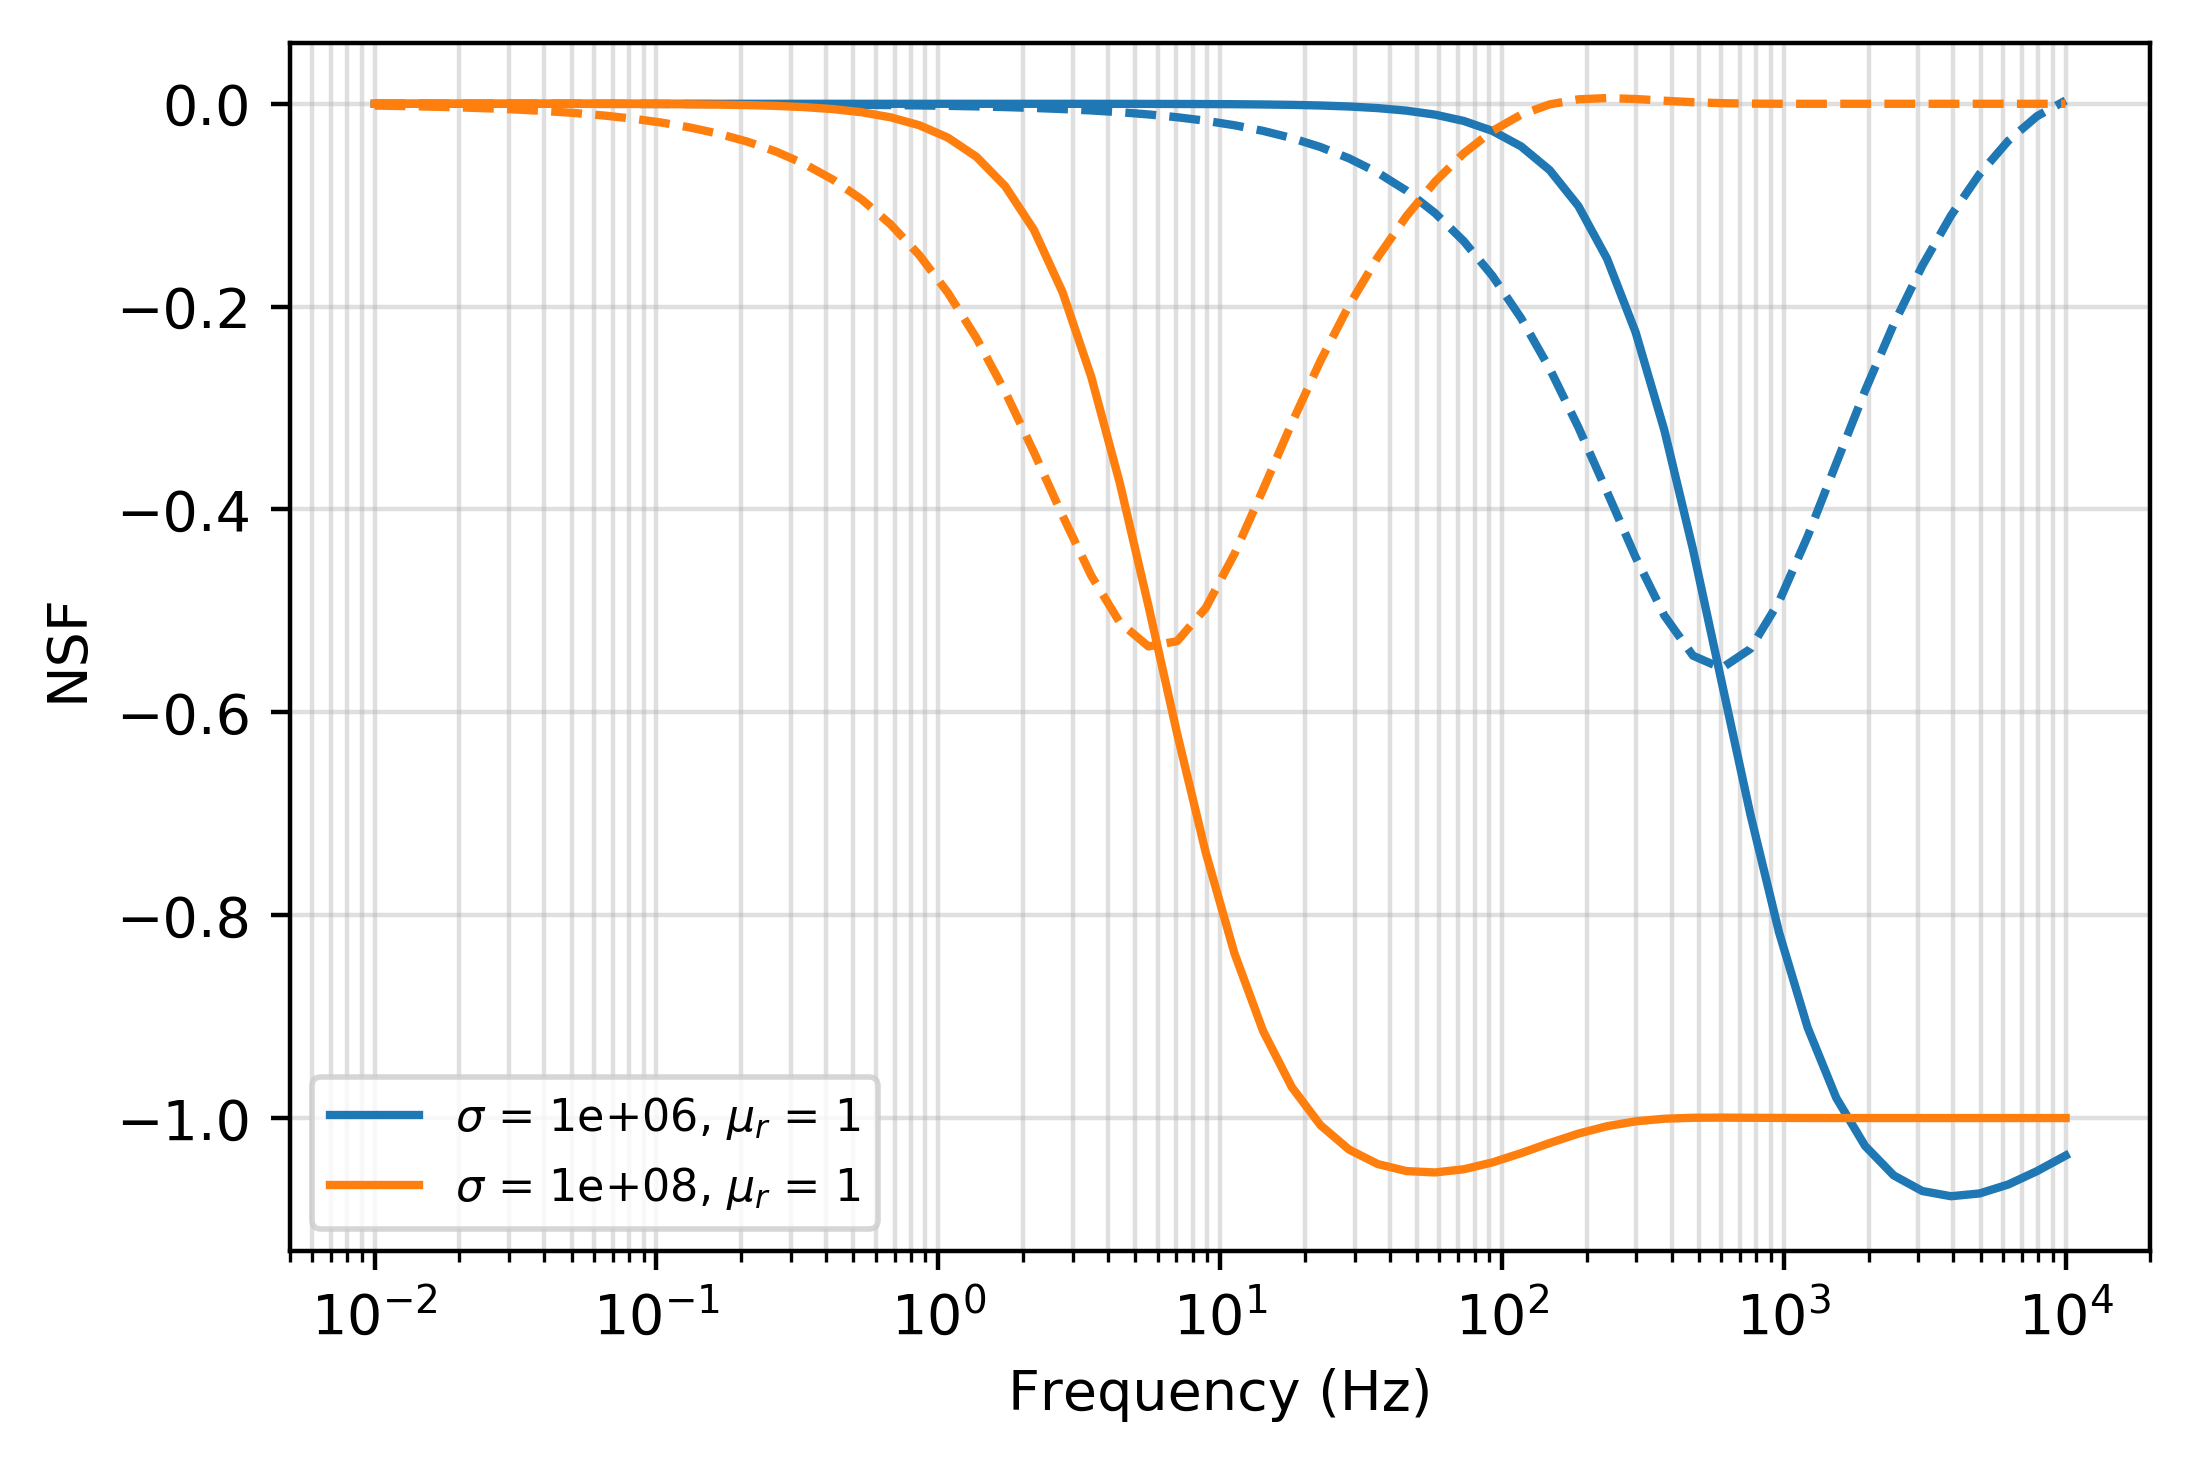

In [180]:
fig, ax = plt.subplots(1, 1, dpi=400)
plot_response_fct(ax=ax, models="conductive")

# fig.savefig("augustin_response_function_mu")

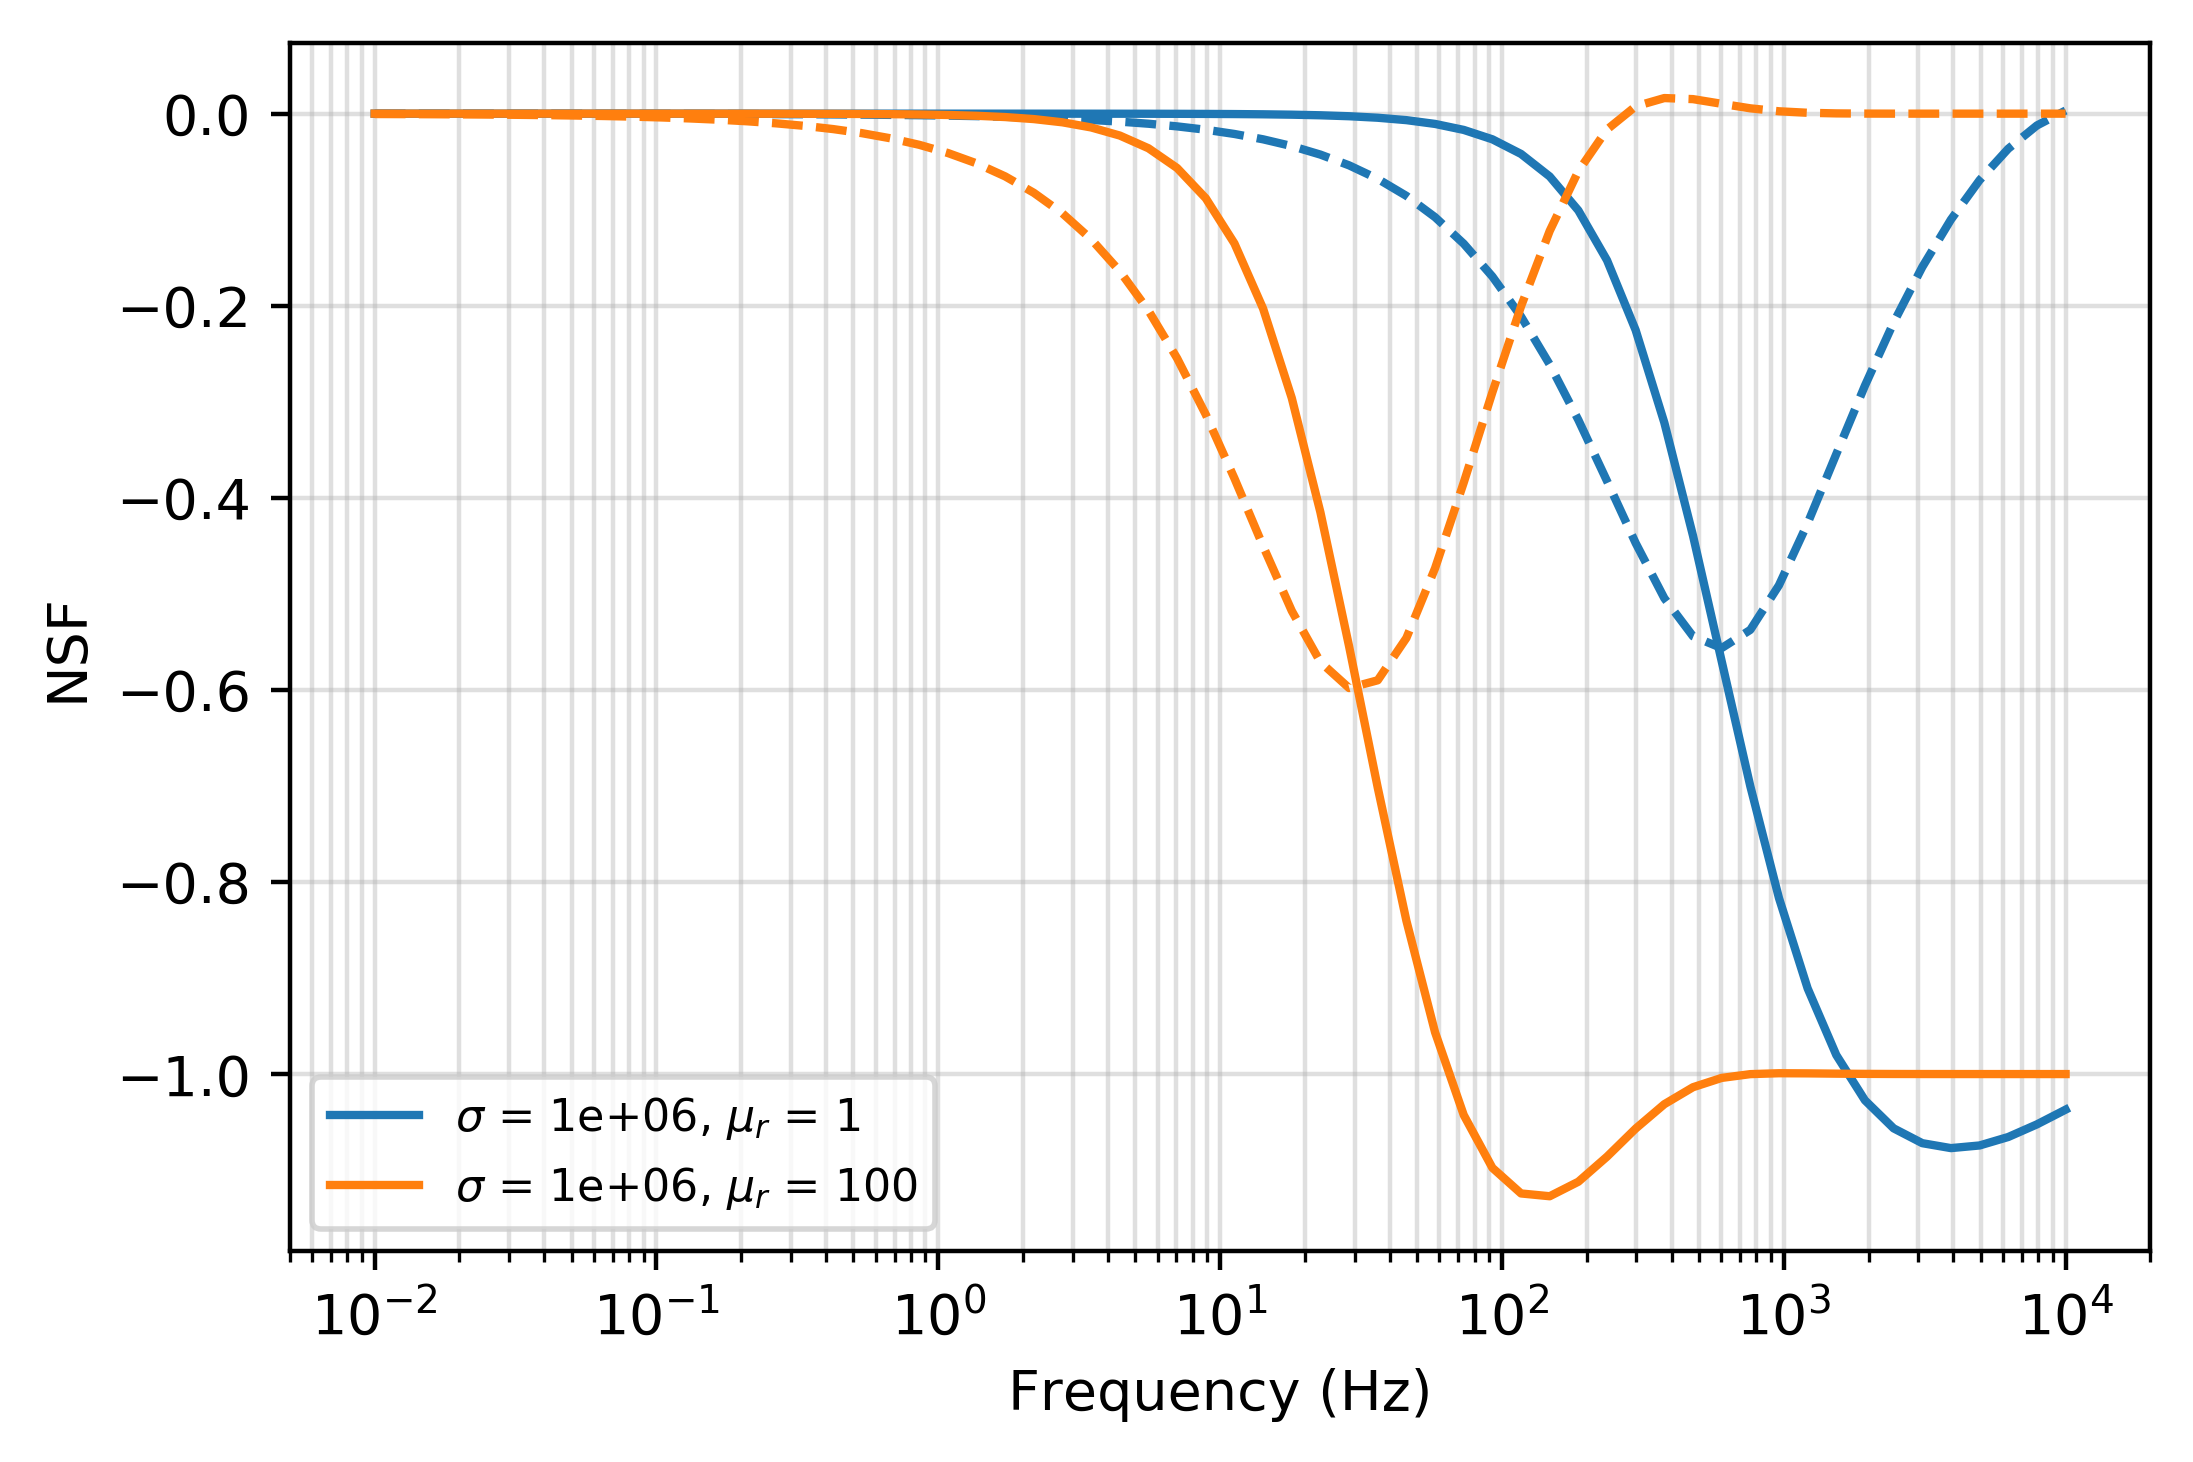

In [181]:
fig, ax = plt.subplots(1, 1, dpi=400)
plot_response_fct(ax=ax, models="permeable")

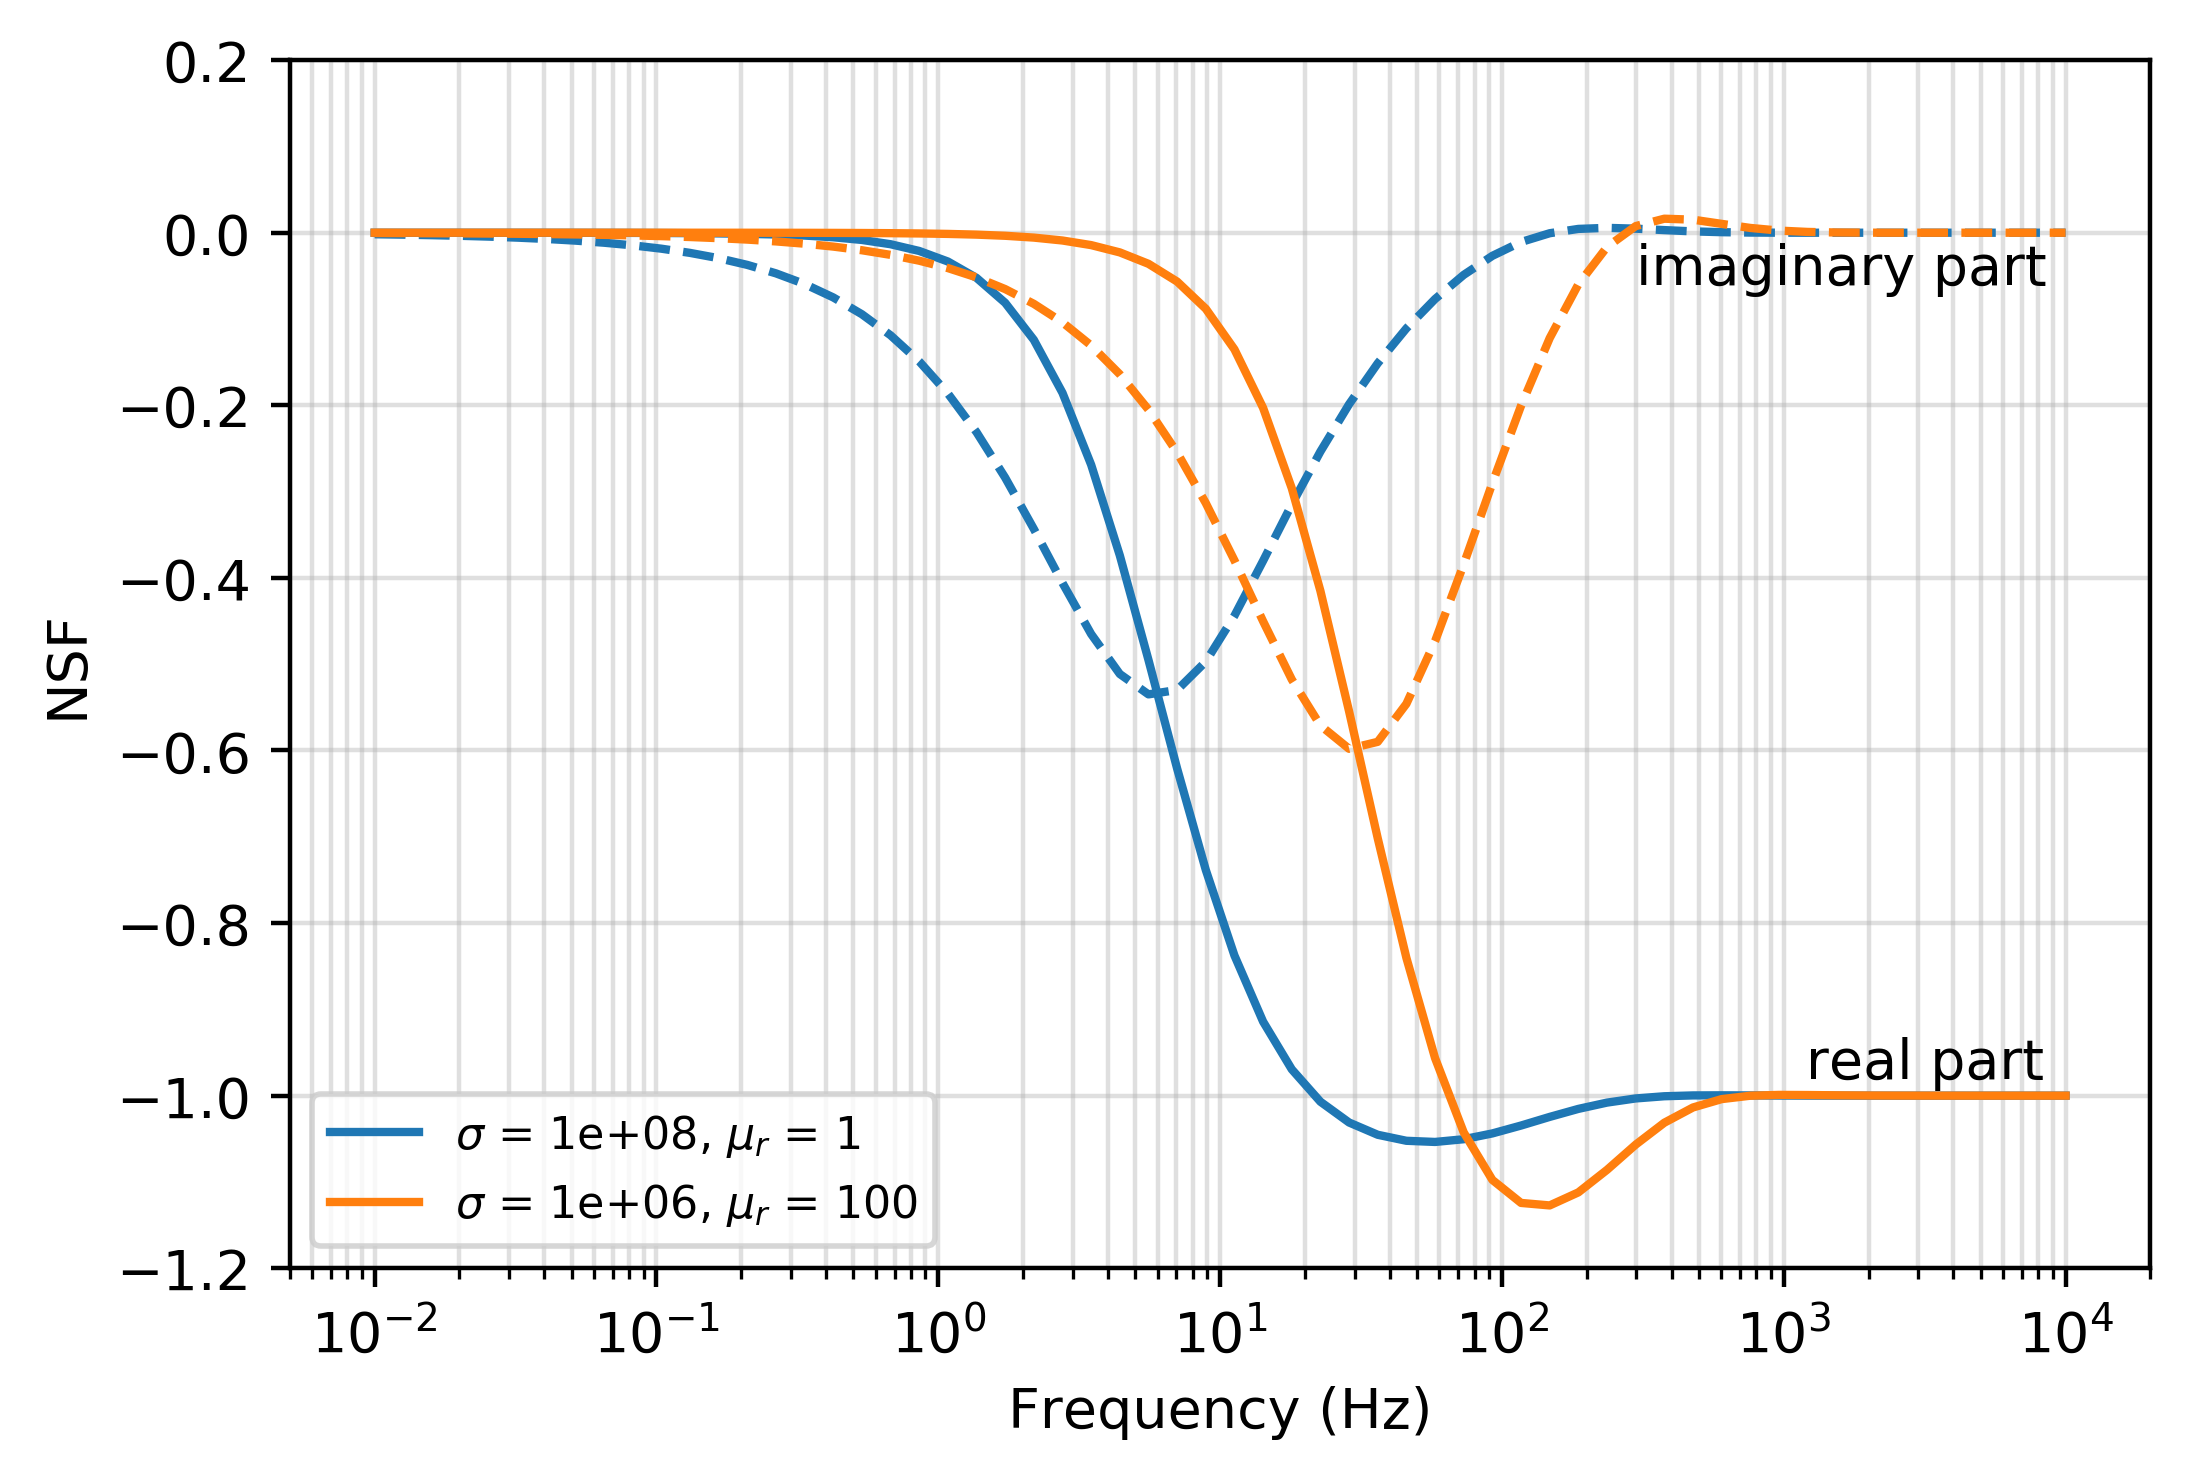

In [183]:
fig, ax = plt.subplots(1, 1, dpi=400)
plot_response_fct(ax=ax, models=["casing_1e+08", "casing_100"], colors = ["C0", "C1"])

ax.set_ylim([-1.2, 0.2])
ax.text(3e2, -0.06, 'imaginary part')
ax.text(1.2e3, -0.98, 'real part')

fig.savefig('fdemNSF')

In [145]:
# Plot the charges
# mesh2D = cylMeshGen.create_2D_mesh().mesh
mesh = mesh_generator.mesh
theta_ind=0
background_key = 'baseline'

def plotCasingResults(
    ax = None,
    clim_max=None, clim_min=None, 
    max_depth=1.1*model_dict[model_names[0]].casing_l, 
    max_r=0.1, top=10., view='charge', model='casing', 
    primsec=['total', 'primary', 'secondary'], 
    casing_outline=True, 
    component='real',
    src_ind=0, 
    show_cb=True
):
    if ax is None: 
        plt.subplots(1, 1, figsize=(6, 7))
        
    assert view.lower() in ['j', 'e', 'b', 'h']

    xlim = max_r*np.r_[-1, 1]  # x-limits in meters
    zlim = np.r_[-max_depth, top]  # z-limits in meters. (z-positive up)
    
    clim = None
    plotopts = {
        'theta_ind': theta_ind,
#         'pcolorOpts':{'norm':LogNorm()}
        'pcolorOpts':{'norm':SymLogNorm(linthresh=3e-13)}
    }
    
    if not clim_max is not None or clim_max != 0.:
        clim = clim_max * np.r_[-1, 1]
        plotopts['clim'] = clim

        if clim_min is not None or clim_min != 0.:
            plotopts['clim'][0] = clim_min
        
    if primsec == 'primary':
        model = background_key

    pp = physpropsDict[model]
    src = survey.srcList[src_ind]
    plotme = fields_dict[model][src, view]
    
    if primsec == 'secondary':
        prim_src = survey.srcList[src_ind]
        plotme = plotme - fields_dict[background_key][prim_src, view]
    
    elif primsec == "conductive":
        plotme = plotme - fields_dict["casing_1"][src, view]

    if view in ['j', 'e']:
        plotme = mesh.aveE2CC * plotme
        _, cb = pp.plot_prop(
            np.absolute(getattr(plotme, component)),
#             getattr(plotme, component),
#             logScale=False
            ax=ax,
            **plotopts 
        )
        
    elif view in ['b', 'h']:
        out = casingSim.plotFace2D(
            mesh,
            plotme, real_or_imag=component, ax=ax, range_x=xlim,
            range_y=zlim, sample_grid=np.r_[np.diff(xlim)/100., np.diff(zlim)/100.],
            logScale=True, clim=clim, mirror=True, 
            stream_threshold = clim[0] if clim is not None else None,
            show_cb=show_cb
        )
    ax.set_title('{} \n {} {} \n f={:1.2f}Hz'.format(
        model, view, component, freqs[src_ind]), 
    )
    ax.set_xlim(xlim)
    ax.set_ylim(zlim)
#         cb.set_label(view)
#     cb.update_ticks()
        
    # plot outline of casing
    if casing_outline is True: 
        m = model_dict[model]
        factor = [-1, 1]
        [
            ax.plot(
                fact * np.r_[m.casing_a, m.casing_a, m.casing_b, m.casing_b, m.casing_a],
                np.r_[m.casing_z[1], m.casing_z[0], m.casing_z[0], m.casing_z[1], m.casing_z[1]],
                'k', 
                lw = 0.5
            ) 
            for fact in factor
        ]
    return out 
    

def plotCasingResultsWidget(
    clim_max=None, clim_min=None, 
    max_depth=1.1*model_dict[model_names[0]].casing_l, 
    max_r=0.1, top=10., view='charge', model='all', 
    primsec=['total', 'primary', 'secondary'],
    component='real',
    src_ind=0
):
    
    model_names = model_names if model == 'all' else [model]
    
    fig, ax = plt.subplots(1, len(model_names), figsize=(len(model_names)*5, 6))
    if len(model_names) == 1:
        ax = [ax]
    
    for a, mod in zip(ax, model_names): 
        a = plotCasingResults(
            ax = a,
            clim_max=clim_max, clim_min=clim_min, 
            max_depth=max_depth, 
            max_r=max_r, top=top, view=view, model=mod, 
            primsec=primsec, 
            casing_outline=True,
            component=component,
            src_ind=src_ind
        )
    
    plt.tight_layout()
    plt.show()

In [146]:
# fig, ax = plt.subplots(1, 3, figsize=(18, 5), dpi=350)

ipywidgets.interact(
    plotCasingResultsWidget,
    clim_max = ipywidgets.FloatText(value=0),
    clim_min = ipywidgets.FloatText(value=0),
    max_depth = ipywidgets.FloatText(value=2500), 
    max_r = ipywidgets.FloatText(value=0.15),
    top = ipywidgets.FloatText(value=10),
    view = ipywidgets.ToggleButtons(
        options=['e', 'j', 'b', 'h'], value='b'
    ),
    model = ipywidgets.ToggleButtons(
        options=model_names, value='casing_1'
    ),
    primsec = ipywidgets.ToggleButtons(
        options=['total', 'primary', 'secondary', 'conductive'], value='total'
    ), 
    component=ipywidgets.ToggleButtons(
        options=['real', 'imag'], value="real"
    ), 
    src_ind=ipywidgets.IntSlider(
        min=0, max=len(freqs)-1, value=0
    )
)   

Widget Javascript not detected.  It may not be installed or enabled properly.


<function __main__.plotCasingResultsWidget>

ValueError: values must all be positive

ValueError: values must all be positive

ValueError: values must all be positive

In [147]:
from matplotlib import rcParams
rcParams['font.size'] = 16

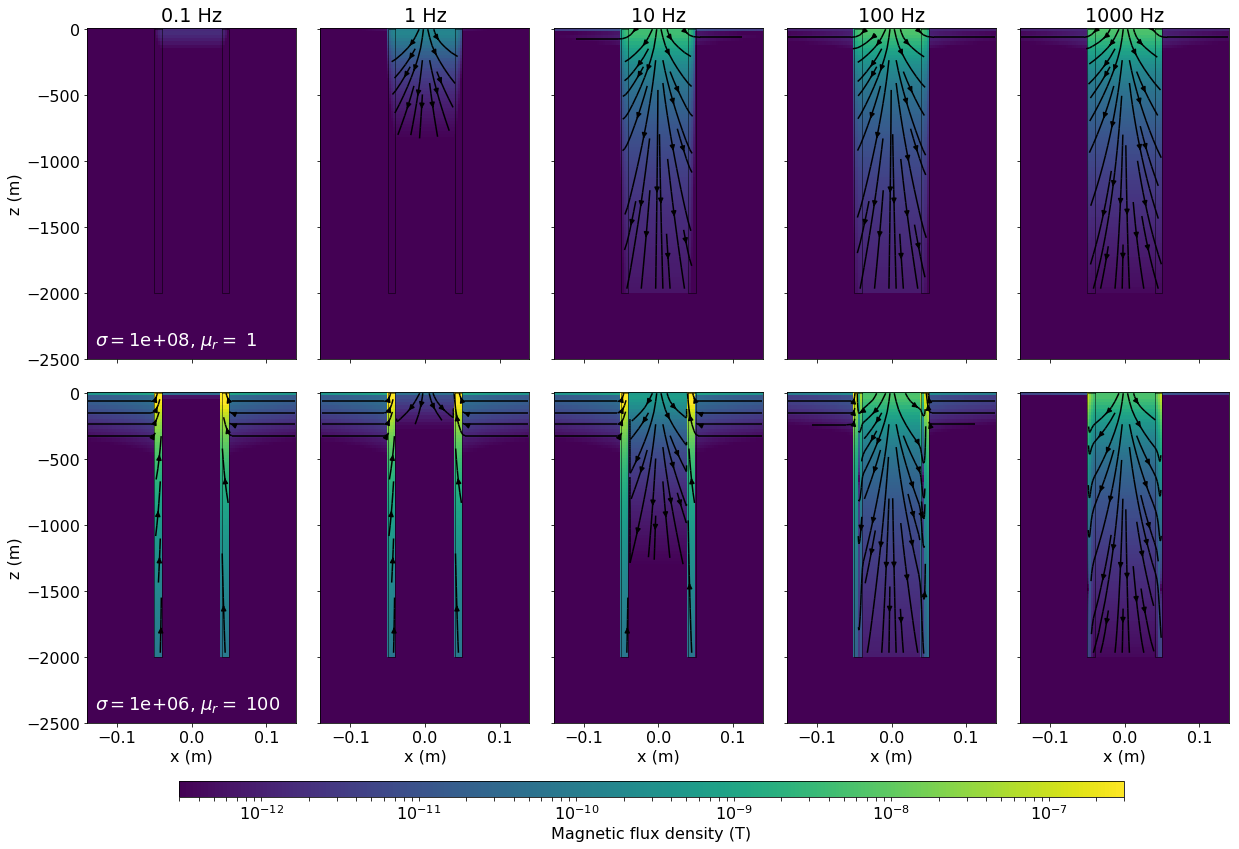

In [148]:
fig, ax = plt.subplots(2, 5, figsize=(3.5*5, 5.5*2))
fig.subplots_adjust(bottom=0.8)

clim = [3e-13, 3e-7]
max_depth = 2500
top = 10
max_r = 0.14
view='b'
primsec="secondary"
component="real"

for i, f in enumerate(freqs[1:]):
    for j, m in enumerate(["casing_1e+08", "casing_100"]):
        a = ax[j, i]
        out = plotCasingResults(
            ax = a,
            clim_max=clim[1], clim_min=clim[0], 
            max_depth=max_depth, 
            max_r=max_r, top=top, view=view, model=m, 
            primsec=primsec, 
            casing_outline=True,
            component=component,
            src_ind=i+1, 
            show_cb=False
        )
        
        
        if j == 0:
            a.set_title("{} Hz".format(f))
            a.set_xticklabels(['']*len(a.get_xticklabels()))
            a.set_xlabel('')
            
            
        else:
            a.set_title("")
            a.set_xlabel("x (m)")
    
        if i > 0:
            a.set_yticklabels(['']*len(a.get_yticklabels()))
            a.set_ylabel('')
        else:
            a.set_ylabel('z (m)')
            mod = model_dict[m]
            a.text(
                -0.13, -2400, "$\sigma = ${:1.0e}, $\mu_r = $ {:1.0f}".format(mod.sigma_casing, mod.mur_casing), 
                color="w", fontsize=18
            )


plt.tight_layout()


cbar_ax = fig.add_axes([0.15, -0.02, 0.75, 0.02])
cb = fig.colorbar(out[0], cbar_ax, orientation='horizontal')
cb.set_label('Magnetic flux density (T)')


In [149]:
fig.savefig('bfedm', dpi=300, bbox_inches="tight")

In [111]:
ax.shape

(2, 5)

In [39]:
P.shape

NameError: name 'P' is not defined

In [ ]:
src_list[i].bPrimary

In [ ]:
    data_re = data[0::2] / src_list[i].bPrimary